In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDatasetEmbedding, UnpairedEmbeddingsDataset
from generators import  OneHotGenerator, SkipOneHotGenerator, SkipTensorEmbeddingGen, TensorEmbeddingGen, OneHotResNetGenerator
from discriminators import PatchDiscriminator, SampleDiscriminator
import os
import glob
import generators

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
PHASES = [1,2,3,4,5]
UNPAIRED = False 
SUPERVISED = True


UNET = True
SKIPCONNECTIONS = False 

RESNET = False

EMBEDDING = True           # Use intervention and phase information during training
if EMBEDDING == True:
    DOWN = False
    BOTTLENECK = True
ONEHOTENCODING = True

PATCH = True                # False = Patch Discriminator, True = Sample Discriminator
SMALLER_TARGET = True      # True = train with target dataset size = PERCENTAGE
PERCENTAGE = 0.5         # percentage of target data


# LR scheduler
MultiStepLR = False
GAMMA = 0.1

ReduceLROnPlateau = False
FACTOR = 0.001
PATIENCE = 2

PolinomialLR = True
power = 1
LR_DECAY_AFTER_EPOCH = 100



DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LEARNING_RATE = 0.0002 #1e-2 
NUM_WORKERS = 16
NUM_EPOCHS = 200

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample

# Use adversarial loss
LAMBDA_DISC = 0.05
GAN_LOSS = False   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = False
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = True 
LAMBDA_SUPERVISED = 5.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

In [3]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize(df_temp, scaler, phase1 = True)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 14)


In [4]:
# select which phases to use
df = df.loc[df['Phasenzuordnung'].isin(PHASES)]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset after selecting Phasenzuordnung 1 (6022044, 14)
Size of the dataset with data from phase 1 (6022044, 14)
Size of Phase 1:  (751120, 14)
Size of Phase 2:  (1370162, 14)
Size of Phase 3:  (1371092, 14)
Size of Phase 4:  (1369343, 14)
SIze of Phase 5:  (1160327, 14)


In [5]:
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    if row['Phasenzuordnung'] == 1:
        df.at[index, 'intervention'] = 0
    elif row['intervention'] == 10:
        if row['contractility'] == 1.0:
            df.at[index, 'intervention'] = 0      # contractility = 1.0 - could be ignored? - phase 0?
        if row['contractility'] == 3.0:
            df.at[index, 'intervention'] = 5      # contractility = 3.0                                        
        if row['contractility'] == 4.0:
            df.at[index, 'intervention'] = 6      # contractility = 4.0

#get unique intervention
print(df['intervention'].unique())

int_1 = df.loc[df['intervention'] == 1]
int_2 = df.loc[df['intervention'] == 2]
int_3 = df.loc[df['intervention'] == 3]
int_4 = df.loc[df['intervention'] == 4]
int_5 = df.loc[df['intervention'] == 5]
int_6 = df.loc[df['intervention'] == 6]

print('Size of intervention 1: ', int_1.shape)
print('Size of intervention 2: ', int_2.shape)
print('Size of intervention 3: ', int_3.shape)
print('Size of intervention 4: ', int_4.shape)
print('Size of intervention 5: ', int_5.shape)
print('Size of intervention 6: ', int_6.shape)

#remove rows with intervention 2, 4 and 6, nearly no data
df = df[df.intervention != 2]
df = df[df.intervention != 4]
df = df[df.intervention != 5]
print(df['intervention'].unique())

[0. 1. 3. 6. 2. 4. 5.]
Size of intervention 1:  (2162838, 14)
Size of intervention 2:  (34544, 14)
Size of intervention 3:  (1532302, 14)
Size of intervention 4:  (26222, 14)
Size of intervention 5:  (19533, 14)
Size of intervention 6:  (1212463, 14)
[0. 1. 3. 6.]


In [6]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
animals = df['animal'].unique()
print(animals)

25
Number of animals after removing those with less than 10 data points:  25
[  8  12  13 108   7  14  11   2  16  10 105 111  17  19   3  15   5  20
 113   4 102   1   9 107 101]


In [7]:
# select animals 3,4,8,11,17 as test animals
test_animals = [3,4,8,11,17]
print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (4744288, 14)

Test data shape: (1197312, 14)

The test dataset is 20.15133970647637 percent of the whole data: 


In [72]:
# get random number between 0 and Percentage
import random

random.seed(1)

# get random number between 0 and Percentage
random_number = random.uniform(0, PERCENTAGE)
print('\nRandom number: ', random_number)


Random number:  0.06718212205620061


In [73]:
df_target = pd.DataFrame()


for animal in df_train['animal'].unique():
    for phase in df_train['Phasenzuordnung'].unique():
        df_temp = df_train.loc[(df_train['animal'] == animal) & (df_train['Phasenzuordnung'] == phase)]
        df_temp = df_temp.iloc[:int(len(df_temp)*PERCENTAGE+random_number)]
        df_target = pd.concat([df_target, df_temp], axis=0)

print('\nShape of df_target:', df_target.shape)
print('\nNumber of animals in df_target:', len(df_target['animal'].unique()))
print('\nNumber of phases in df_target:', len(df_target['Phasenzuordnung'].unique()))
print(df_train.shape[0] / df_target.shape[0])


Shape of df_target: (2372118, 14)

Number of animals in df_target: 20

Number of phases in df_target: 5
2.0000219213378085


In [74]:
# Generator
if UNET:
    if ONEHOTENCODING and not SKIPCONNECTIONS:
        gen_target = OneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
        gen_source = OneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if ONEHOTENCODING and SKIPCONNECTIONS:
    #     gen_target = SkipOneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = SkipOneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if not ONEHOTENCODING and SKIPCONNECTIONS:
    #     gen_target = SkipTensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = SkipTensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if not ONEHOTENCODING and not SKIPCONNECTIONS:
    #     gen_target = TensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = TensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not UNET:
    if ONEHOTENCODING:
        gen_target = OneHotResNetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS= 1, WINDOWSIZE = WINDOW, blocks=6, Down = False, Bottleneck = True)
        gen_source = OneHotResNetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS= CHANNELS, WINDOWSIZE = WINDOW, blocks=6, Down = False, Bottleneck = True)


# Discriminator
if PATCH:
    disc_target = PatchDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = PatchDiscriminator(CHANNELS = CHANNELS).to(DEVICE)
if not PATCH:
    disc_target = SampleDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = SampleDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers 
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Scheduler
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                           factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                           min_lr=1e-6,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                            factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                            min_lr=1e-6,
                                                    )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[5,6,7,8], gamma=GAMMA)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[5,6,7,8], gamma=GAMMA)

if PolinomialLR:
    gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = power,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = power,
                                                    )

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss() 

In [75]:
if SUPERVISED:
    train_dataset = AnimalDatasetEmbedding(df_target, source_signals, target_name = TARGET,  window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)



# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

In [76]:
def gen_signals(fake_target, fake_source, target, source):
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) 


# @torch.cuda.amp.autocast()
def get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    
    # discriminator loss
    disc_target_loss = discriminator_loss(disc_target, target, fake_target) * LAMBDA_DISC
    disc_source_loss = discriminator_loss(disc_source, source, fake_source) * LAMBDA_DISC
    disc_loss = (disc_source_loss + disc_target_loss) #/ 2

    return disc_loss, disc_source_loss, disc_target_loss


In [77]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, source_phase, source_intervention, target_phase, target_intervention in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        source_phase = source_phase.to(DEVICE)
        source_intervention = source_intervention.to(DEVICE)
        target_phase = target_phase.to(DEVICE)
        target_intervention = target_intervention.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach()
            fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                                                        # source, target, disc_source, disc_target, fake_source, fake_target

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()

        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        # out = supervised_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
        #                         gen_source, gen_target, disc_source, disc_target, fake_target, fake_source)

        # g_loss, g_source_loss, g_target_loss, sup_source_loss, sup_target_loss = out
        g_loss = 0

        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) 
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        g_loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
        
        sup_source_loss = l1(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source)
        sup_target_loss = l1(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), target)

        g_loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    

        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()

    if ReduceLROnPlateau == True:  
        disc_scheduler.step(d_loss)
        gen_scheduler.step(g_loss)

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if PolinomialLR == True and (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()

100%|██████████| 200/200 [3:00:04<00:00, 54.02s/it]  


In [78]:
source_losses = []
target_losses = []

disc_source.eval()  # set discriminator to evaluation mode
disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
gen_target.eval()
gen_source.eval()

for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    # source_reconstructed = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # target_reconstructed = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # l1_source = l1(source, fake_source)
    # l1_target = l1(target, fake_target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 0.15109375058180644
Average L1 loss of target signals: 0.33936059261344803
Min and max loss of source signals: (0.11252643913030624, 0.19378165900707245)
Min and max loss of target signals: (0.2706141471862793, 0.42514243721961975)
Median loss of source signals: 0.1506810337305069
Median loss of target signals: 0.33814579248428345


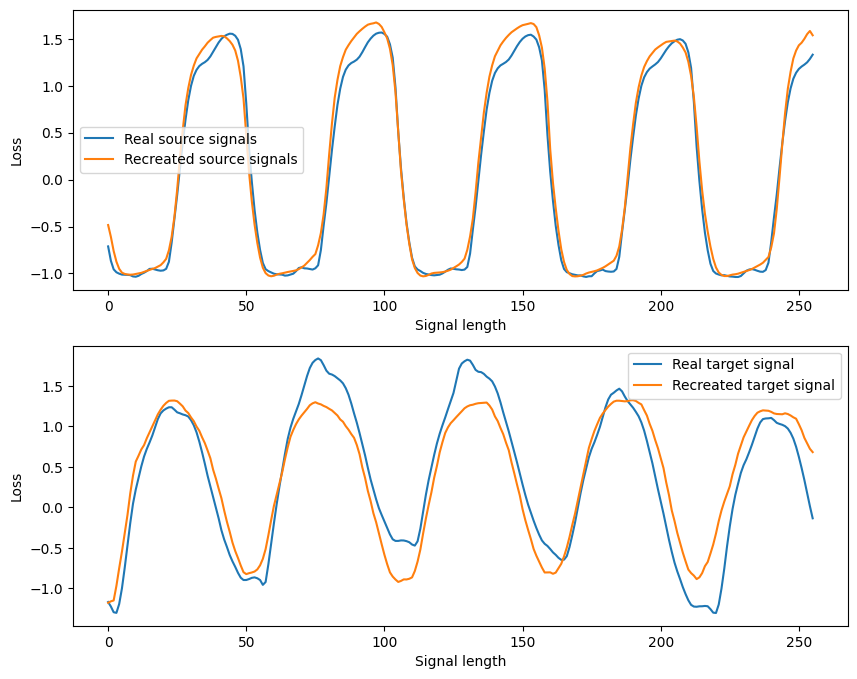

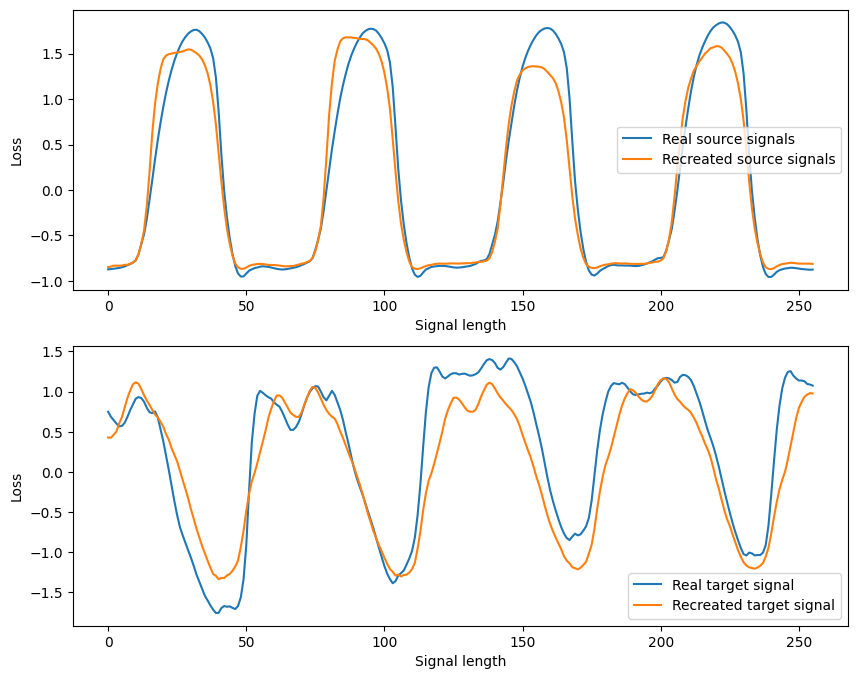

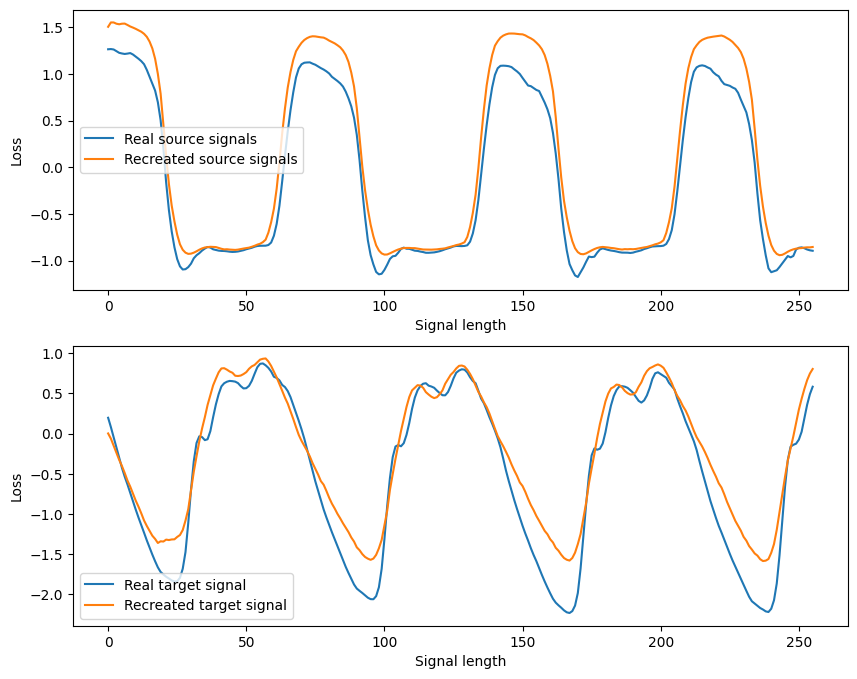

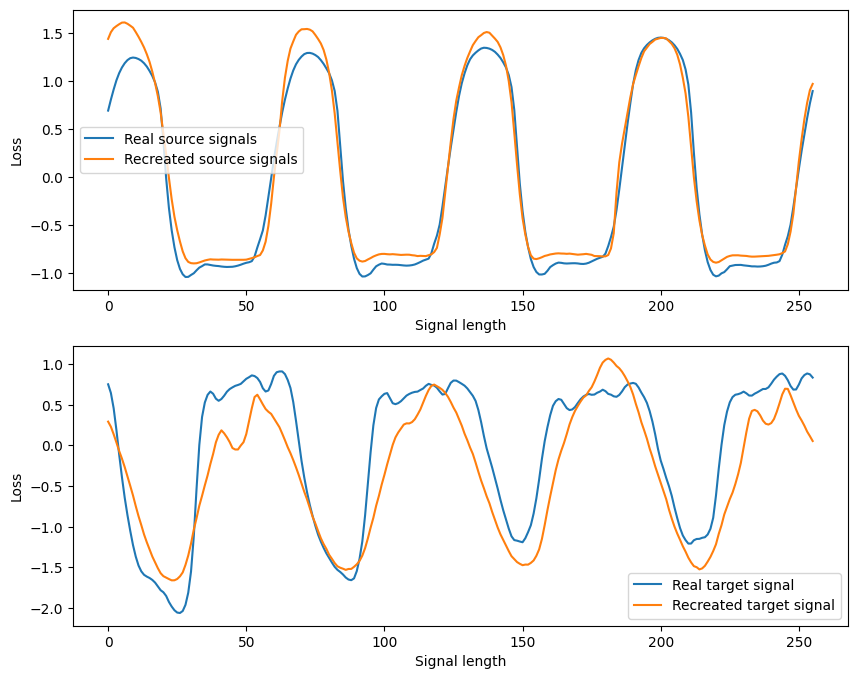

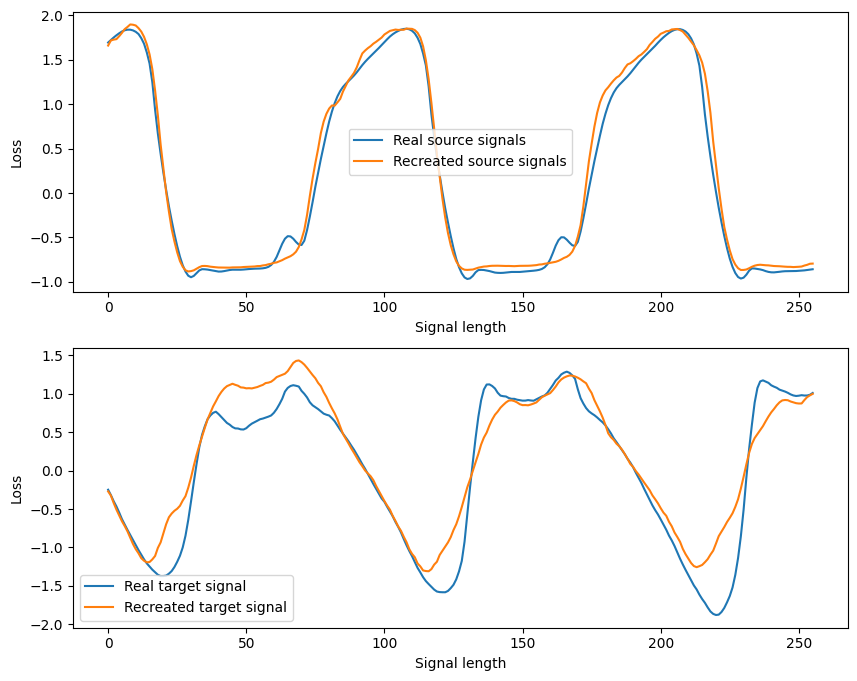

In [79]:
#  Generate signals
idx = 0
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
    if idx == 5:
        break              
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source[:256].cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source[:256].cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target[:256].cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target[:256].cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1    

In [80]:
# Verify L1 loss of reconstructed and real signals, per phase and intervention
# array([ 0.,  1.,  3., 10.,  2.,  4.,  9.])
# df of phase 1
df_phase_1 = df_test.loc[df_test['Phasenzuordnung'].isin([1])]
df_phase_2 = df_test.loc[df_test['Phasenzuordnung'].isin([2])]
df_phase_3 = df_test.loc[df_test['Phasenzuordnung'].isin([3])]
df_phase_4 = df_test.loc[df_test['Phasenzuordnung'].isin([4])]
df_phase_5 = df_test.loc[df_test['Phasenzuordnung'].isin([5])]

# 1.,  3., 10.,  2.,  4.
df_int_0 = df_test.loc[df_test['intervention'].isin([0])]
df_int_1 = df_test.loc[df_test['intervention'].isin([1])]
df_int_2 = df_test.loc[df_test['intervention'].isin([2])]
df_int_3 = df_test.loc[df_test['intervention'].isin([3])]
df_int_4 = df_test.loc[df_test['intervention'].isin([4])]
df_int_5 = df_test.loc[df_test['intervention'].isin([5])]
df_int_6 = df_test.loc[df_test['intervention'].isin([6])]

In [99]:
verify_dataset = AnimalDatasetEmbedding(df_int_6, source_signals, target_name = TARGET, window_length = WINDOW)
verify_loader = DataLoader(verify_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

In [100]:
source_losses = []
target_losses = []

disc_source.eval()  # set discriminator to evaluation mode
disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
gen_target.eval()
gen_source.eval()

for source, target, source_phase, source_intervention, target_phase, target_intervention in verify_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    # source_reconstructed = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # target_reconstructed = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # l1_source = l1(source, fake_source)
    # l1_target = l1(target, fake_target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 0.1592053771018982
Average L1 loss of target signals: 0.30051206187768414
Min and max loss of source signals: (0.14166322350502014, 0.18008066713809967)
Min and max loss of target signals: (0.24230332672595978, 0.3551868200302124)
Median loss of source signals: 0.16041461378335953
Median loss of target signals: 0.3039771467447281
